<a href="https://colab.research.google.com/github/nthne/VietFinanceLab-Analyzing-Market-Trends-and-Forecasting-Future-Price/blob/main/SVR_predictsecondhalf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Nested CV](#2-bullet)
3. [Retrain and Evaluate Model](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Added /content/drive/MyDrive/VietFinanceLab-Analyzing-Market-Trends-and-Forecasting-Future-Price/SVR to sys.path
<class 'pandas.core.frame.DataFrame'>
Index: 4506 entries, 0 to 4505
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         4506 non-null   float64
 1   High         4506 non-null   float64
 2   Low          4506 non-null   float64
 3   Close        4506 non-null   float64
 4   Volume       4506 non-null   int64  
 5   TradingDate  4506 non-null   object 
 6   Code         4506 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 281.6+ KB


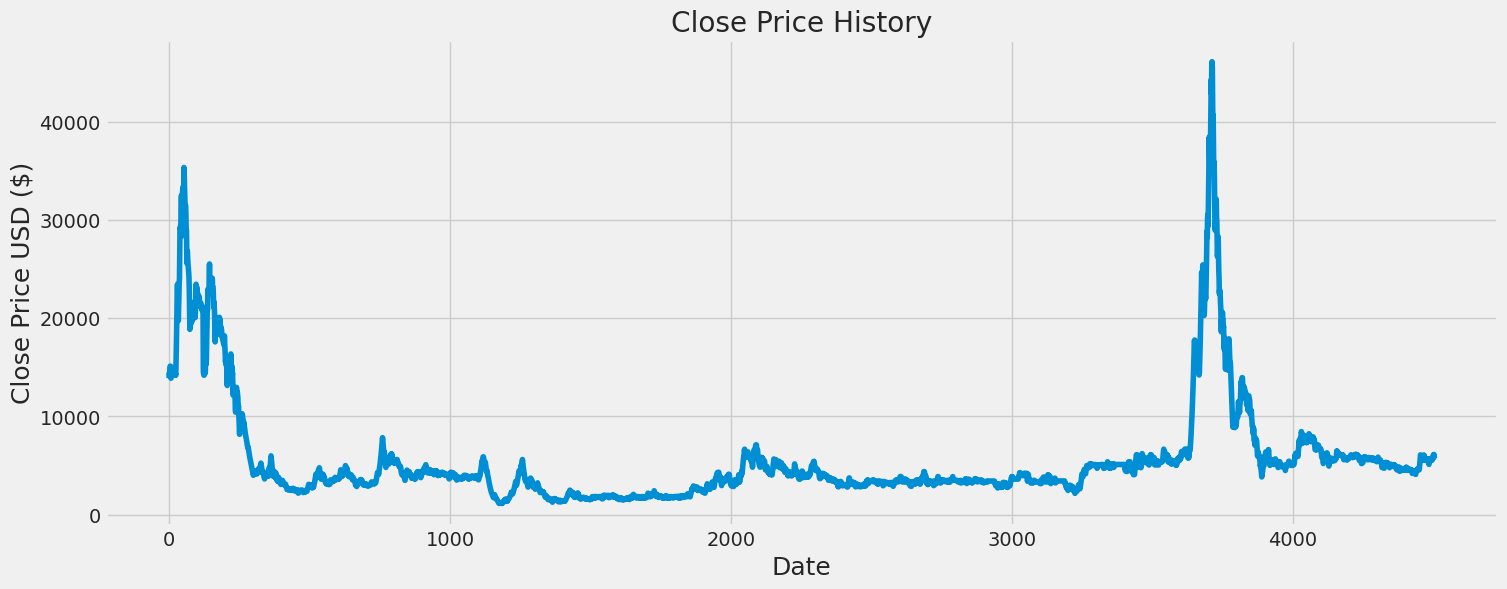

DataPreprocessing module imported successfully!


In [2]:
import sys
import os

# Get the current working directory and the mounted drive path
# If your file is in a subdirectory of the mounted drive, specify the full path
drive_path = '/content/drive/MyDrive/VietFinanceLab-Analyzing-Market-Trends-and-Forecasting-Future-Price/SVR' # <--- REPLACE WITH YOUR ACTUAL PATH TO THE DIRECTORY CONTAINING DataPreprocessing.py

# Add the directory to the system path
if drive_path not in sys.path:
    sys.path.append(drive_path)
    print(f"Added {drive_path} to sys.path")

# Now attempt to import the module
try:
    from DataPre import *
    print("DataPreprocessing module imported successfully!")
except ModuleNotFoundError:
    print(f"Error: Module 'DataPreprocessing' not found in {sys.path}")
    print("Please verify the path to the DataPreprocessing.py file and update drive_path.")


## 2. [Nested CV - Predict Second Half](#2-bullet)

We try to use nested CV for time series to try to tune hyperparameters. After getting best hyperparameters, we retrain model and then evaluate

### Create dataset

In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train =x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

### Predict Second Half

In [5]:
def performSVR(X_train, Y_train, X_test, Y_test, parameters):

    # Create and train the SVR model
    svr_model = SVR(C = parameters['C'], kernel = parameters['kernel'], gamma = parameters['gamma'])
    svr_model.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred_train = svr_model.predict(X_train)
    Y_pred_test = svr_model.predict(X_test)

    # Calculate accuracy
    accuracy_train = r2_score(Y_train, Y_pred_train)
    accuracy_valid = r2_score(Y_test, Y_pred_test)

    mse_train = mean_squared_error(Y_train, Y_pred_train)
    mse_valid = mean_squared_error(Y_test, Y_pred_test)

    return [accuracy_train, accuracy_valid, mse_train, mse_valid]

In [6]:
def predict_second_half(X, y, params):
    train_size = len(X) // 2
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.5, shuffle=False)

    # Assuming you have a validation set stored in variables called 'val_data' and 'val_target'
    # Splitting the training set into training and validation subsets
    X_sub_train, x_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.5, shuffle=False)

    # Training and evaluating the model
    accuracy_train, accuracy_valid, mse_train, mse_valid = performSVR(X_sub_train, y_sub_train, x_val, y_val, params)


    return accuracy_train, accuracy_valid, mse_train, mse_valid



In [7]:
from sklearn.model_selection import ParameterGrid

# Định nghĩa siêu tham số để tinh chỉnh
param_grid = {
    'C': [0.01, 0.1, 1, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma' : [0.01, 0.001, 1]
}

# Chuyển đổi siêu tham số thành danh sách các tham số có thể
param_list = list(ParameterGrid(param_grid))

# Lưu kết quả của các mô hình đã được đánh giá
results = []

# Lặp qua từng bộ tham số để đánh giá mô hình
for i,params in enumerate(param_list):
    print(f"Evaluating parameters {i+1}: {params}")

    # Thực hiện Cross Validation với mô hình SVR và siêu tham số tương ứng
    accuracy_train, accuracy_valid, mse_train, mse_valid = predict_second_half(x_for_train, y_for_train, params)

    # Lưu kết quả vào danh sách
    results.append({
        'parameters': params,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'mse_train': mse_train,
        'mse_valid': mse_valid
    })

# In kết quả của các mô hình đã đánh giá
for result in results:
    print("Parameters: ", result['parameters'])
    print("Train Accuracy: ", result['accuracy_train'])
    print("Valid Accuracy: ", result['accuracy_valid'])
    print("Train MSE: ", result['mse_train'])
    print("Valid MSE: ", result['mse_valid'])
    print("------------------------")

# Sắp xếp danh sách kết quả theo trường 'accuracy_valid' tăng dần
sorted_results = sorted(results, key=lambda x: x['mse_valid'], reverse=False)

# Lấy bộ tham số đầu tiên từ danh sách đã sắp xếp
best_parameters = sorted_results[0]['parameters']

# In ra bộ tham số có accuracy_valid lớn nhất
print("Best Parameters: ", best_parameters)

Evaluating parameters 1: {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 2: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 3: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 4: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 5: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluating parameters 6: {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
Evaluating parameters 7: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Evaluating parameters 8: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
Evaluating parameters 9: {'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}
Evaluating parameters 10: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 11: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 12: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 13: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 14: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluat

## 3. [Retrain and Evaluate Model](#4-bullet)

### Create training and testing data

In [8]:
training_size=int(len(dataset)*0.5)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2253, 1)
test_data:  (2253, 1)


In [9]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (2222, 30)
y_train:  (2222, 1)
x_test:  (2222, 30)
y_test (2222, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [10]:
# Create and train the SVR model
svr_model = SVR(C = 1, kernel = 'linear', gamma = 0.01)
svr_model.fit(x_train, y_train)

SVR(C=1, gamma=0.01, kernel='linear')

In [11]:
predictions = svr_model.predict(x_test)
predictions = predictions.reshape(-1,1)


predictions_train = svr_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)


In [12]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [13]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

In [14]:
df_concatenated

,Close_predict,Close_test
0,4420.728238,4170.0
1,4206.591930,4390.0
2,4411.342033,4670.0
3,4736.680393,4720.0
4,4801.388052,5000.0
...,...,...
2217,5808.471263,5810.0
2218,5837.649102,6090.0
2219,6169.229568,5800.0
2220,5828.009522,6130.0


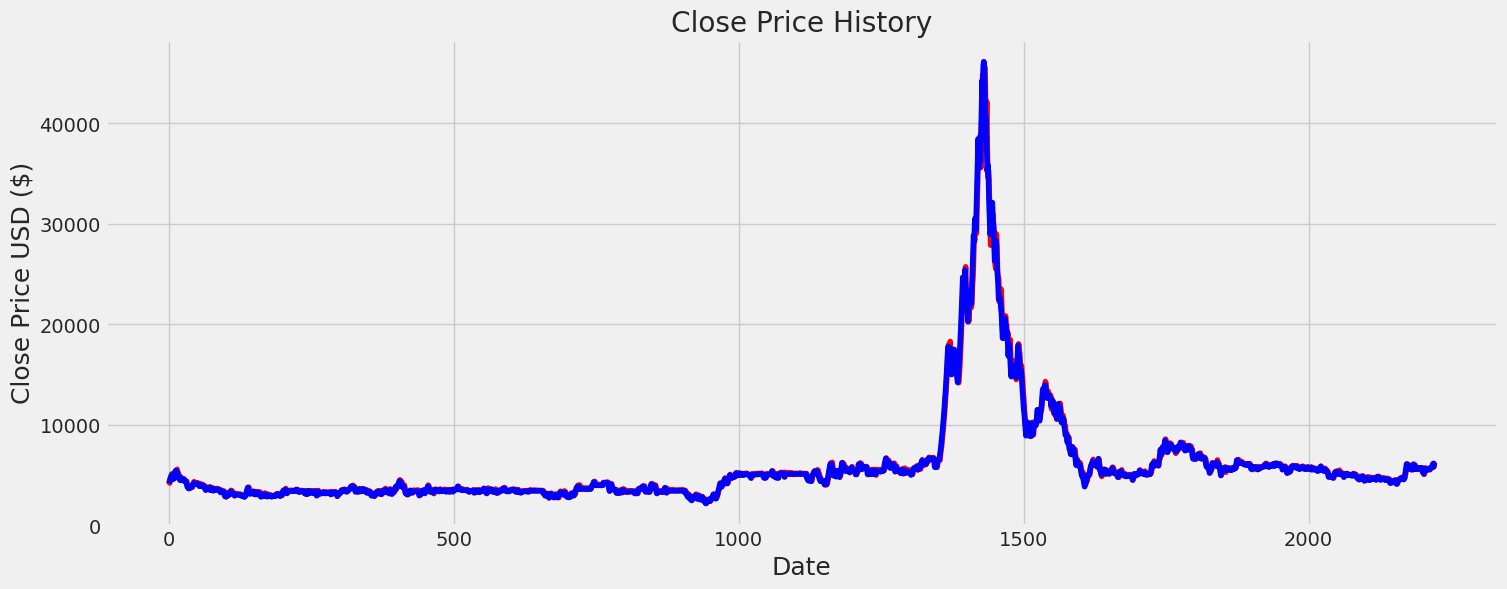

In [15]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [16]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [17]:

mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.03018641219757976
Train Mean Squared Error: 0.003587938634693366
Train R-squared: 0.9964120613653067


In [18]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.03621144092954873
Test Mean Squared Error: 0.005365571992115118
Test R-squared: 0.9946344280078849
